#  SN Rate Metric


utilities needed the code: h5py, psnid (from SNANA package);

**Import lsst and utilities packages**

**template_lc** is a python class that allows to produce the template_lc.txt file (see below for the specifics) with the template lc in a redshift range that has to be specified by the user


In [1]:
import sys, os, h5py, pickle, warnings, subprocess
sys.path.append('/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs')
from opsimUtils import *
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial
from lsst.sims.maf.utils import m52snr, radec2pix
import pandas as pd
from pylab import cm
import time
from itertools import groupby
os.environ['SNANA_DIR']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNANA'
os.environ['SNDATA_ROOT']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNDATA_ROOT'
os.environ['LSST_DIR']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/util_snrmetric'
%matplotlib inline

The following cell imports the opsims database names and create empty files to upload the results in.

In [2]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))
    
dbRuns = show_opsims(dbDir)
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

################ LC TEMPLATE #############

We import the module to simulate the K-corrected templates' ligh curves within a given redshift range. 

MAF constrains to select the data in the Opsim

In [3]:
surveyDuration = 1
init = 1
sqlconstraint_WFD = '(filter= "u" or filter= "g" or  filter = "r" or filter="i"  or filter="z")'
sqlconstraint_WFD+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25 )
sqlconstraint_WFD+='and proposalId=1'

############################## SN position simulator  ######################

Here the RA and DEC of the observations are defined.

**slicermode**: indicate the type of slicer (the way you want to sort the data form the database)
 
        - SlicePoints: A spatial slicer that allows to select specifics pointings. A set of RA & DEC is passed to the API to extract approximated observational features in the injected positions.
         
        - HealpixSlicer: A spatial slicer that evaluates pointings on a healpix-based grid (the grid area divide the observed sky in nside x nside bins). The footprint is tasselated in a number of healpixels of equal area, which define the resolution of the observation.
        
        - Unislicer: This slicer simply returns the indexes of all data points. No slicing done at all.
   

In [4]:
#slicermode= input('select your Slicer (HealpixSlicer, SlicerPoints, UniSlicer): ')
#if slicermode =='HealpixSlicer':
nside = 8
slicer = slicers.HealpixSlicer(nside=nside)
#slicer=slicers.UniSlicer()
pixelarea = hp.nside2pixarea(nside,degrees=True)


Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes


In [203]:
import template_lc

In [204]:
sngroups ={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)},
              'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)},                        # 10
              'IIn':{'IIn':(['2010jl'],45),
                     'IIna':(['1998S'],45), 
                     'IIpec':(['1997cy','2005gj'],10)},
              'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}, 
              'SLSN' : {'SLSN':(['2008es'],100)}}

In [205]:
temp = template_lc.template_lc(sn_group=sngroups ,
                               z_min=0.1,z_max= 0.9,z_step=0.1)
obs_template = temp.run()

I'm reading the templates


In [8]:
obs_template['magobs'].keys()

dict_keys(['1990N', '1992A', '1994D', '2002bo', '1991T', '1999ee', '1991bg', '2000cx', '2002cx', '1999em', '2004et', '2009bw', '1999br', '1999gi', '2005cs', '1992H', '1993J', '2008ax', '1987A', '2010jl', '1998S', '1997cy', '2005gj', '2009jf', '2008D', '1994I', '2004aw', '2007gr', '1998bw', '2008es'])

Check the number of filters for which the template's max is above the depth threshold for each template, see Table 3.2 in https://arxiv.org/pdf/0912.0201.pdf

In [9]:
mlc = {f: np.array([min(obs_template['magobs'][t][0.8][f]) for t in obs_template['magobs'].keys()]) for f in ['r','g','i']}
mlc01 = {f: np.array([min(obs_template['magobs'][t][0.1][f]) for t in obs_template['magobs'].keys()]) for f in ['r','g','i']}

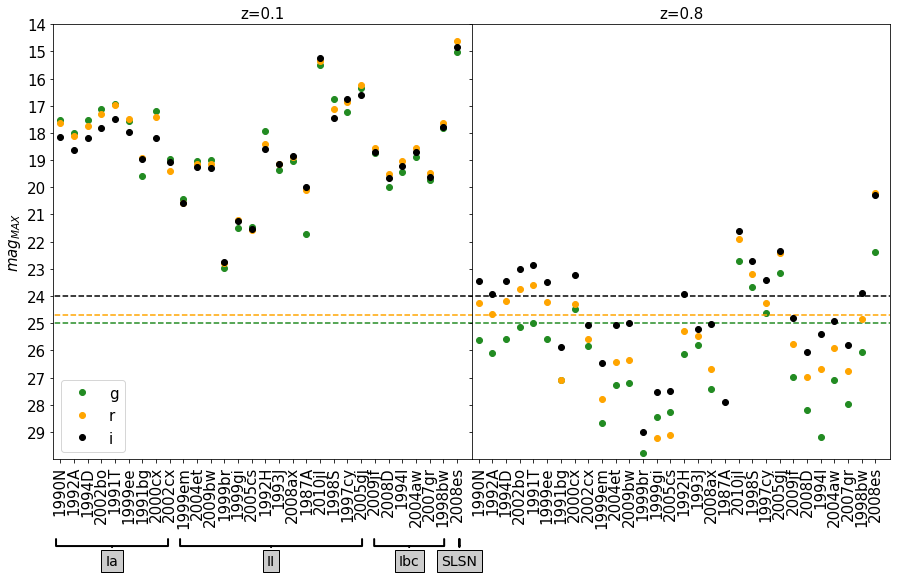

In [10]:
fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(1,2, wspace=0)
ax = gs.subplots(sharey=True)
maglim = [25.0,24.7,24]
for j,(f,c) in enumerate(zip(['g','r','i'],['forestgreen','orange','black'])):
    ax[0].plot(np.arange(len(obs_template['magobs'])),mlc01[f],'o',color=c,label=f)
    ax[0].plot(np.linspace(-20,50,100),np.ones(100)*maglim[j],'--',color=c)
    ax[1].plot(np.arange(len(obs_template['magobs'])),mlc[f],'o',color=c,label=f)
    ax[1].plot(np.linspace(-20,50,100),np.ones(100)*maglim[j],'--',color=c)
ax[1].set_title('z=0.8', fontsize=15)
ax[1].set_xlabel('')
ax[1].set_xlim([-0.5,30.1])
ax[1].set_yticks(np.arange(len(obs_template['magobs'])))
ax[1].set_xticks(np.arange(len(obs_template['magobs'])))
ax[1].set_xticklabels(obs_template['magobs'].keys(),rotation=90, fontsize=15)

ax[1].tick_params(axis="both",labelsize=15)
ax[1].set_ylim([30,14])
ax[0].set_title('z=0.1', fontsize=15)
ax[0].legend(loc=3, fontsize=15)
ax[0].set_xlabel('')
ax[0].set_ylabel(r'$mag_{MAX}$', fontsize=15)
ax[0].set_xlim([-0.5,30.1])
ax[0].set_xticks(np.arange(len(obs_template['magobs'])))
ax[0].set_xticklabels(obs_template['magobs'].keys(),rotation=90, fontsize=15)

ax[0].tick_params(axis="both",labelsize=15)
ax[0].set_ylim([30,14])
ax[0].annotate('Ia', xy=(0.14, -0.20), xytext=(0.14, -0.25),
            fontsize=14, ha='center', va='bottom', xycoords='axes fraction', 
            bbox=dict(boxstyle='square', fc='0.8'),
            arrowprops=dict(arrowstyle='-[, widthB=4., lengthB=.5', lw=2.0))

ax[0].annotate('II', xy=(0.52, -0.20), xytext=(0.52, -0.25),
            fontsize=14, ha='center', va='bottom', xycoords='axes fraction', 
            bbox=dict(boxstyle='square', fc='0.8'),
            arrowprops=dict(arrowstyle='-[, widthB=6.5, lengthB=.5', lw=2.0))
ax[0].annotate('Ibc', xy=(0.85, -0.20), xytext=(0.85, -0.25),
            fontsize=14, ha='center', va='bottom', xycoords='axes fraction', 
            bbox=dict(boxstyle='square', fc='0.8'),
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=2.0))
ax[0].annotate('SLSN', xy=(0.97, -0.20), xytext=(0.97, -0.25),
            fontsize=14, ha='center', va='bottom', xycoords='axes fraction', 
            bbox=dict(boxstyle='square', fc='0.8'),
            arrowprops=dict(arrowstyle='-[, widthB=0, lengthB=.5', lw=2.0))
plt.show()

- get_Col is a metric that allows to extract specific columns from the Opsims database
- transientsmetric is a metric that estimates the classification and detection efficiency of the Opsims 

In [11]:
class get_Col(BaseMetric):
    def __init__(self,  metricName='get_Col',Col=['expMJD',
                 'fiveSigmaDepth','filter', 'fieldRA', 'fieldDec', 
                 'seeingFwhmEff'], dataout=False, **kwargs):
        
        """
    Parameters:
    ___________
    Survey Parameters:
        Col = an array with the column names form the Opsim database
    __________
    
    OUTPUT:
        Dictionary with the column values
        
    """
        
        self.Col= Col
                
        # if you want to get the light curve in output you need to define the metricDtype as object
        super(get_Col, self).__init__(self.Col,metricDtype='object', units='',
                                                       metricName=metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # Sort the entire dataSlice in order of time.
        dataSlice.sort(order='observationStartMJD')
        r = {c:dataSlice[c] for c in self.Col}
        r.update({'coo':(np.median(dataSlice['fieldRA']), np.median(dataSlice['fieldDec']))})
        return r
            

In [12]:
class SNclassification_metric(BaseMetric):
    """
    Parameters:
    ___________
    Survey Parameters:
        mjdCol= MJD observations column name from Opsim database      (DEFAULT = expMJD) 
        m5Col= Magnitude limit column name from Opsim database      (DEFAULT = fiveSigmaDepth)
        filterCol= Filters column name from Opsim database      (DEFAULT = filter)
        RACol= RA column name from Opsim database      (DEFAULT = fieldRA)
        DecCol= Dec column name from Opsim database      (DEFAULT = fieldDec)
        surveyDuration= Survey Duration      (DEFAULT = 10)
        surveyStart= Survey start date      (DEFAULT = None)
   
    Template parameters:
        templates= dictionary with all the SNe templates     (DEFAULT= {'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],100)}})
        z = array with z min, z max and z step for the redshift range     (DEFAULT= [0.1,1,0.1])
        explosiontime = times of explosion array      (DEFAULT= None)
        
    
    Detection parameters:
        detectSNR= dictionary with SNR threshold for each filter    (DEFAULT = {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5})
        nFilters= None or number to define the threshold number of filter to be detected  (DEFAULT = None)
        ndetect= integer, threshold number of points detected on the lightcurve   (DEFAULT = 3)
        nclass= integer, threshold number of points detected on the lightcurve to be classified  (DEFAULT = 3)
    __________
    
    OUTPUT:
        dataout = True, Dictionary containing the coordinates of all the SNe detected, the time of explosions and the number of 
        detected and no-detected along with the number of classifies, no-classified and mis-classified SNe for each type
        
        dataout = False, fraction of correctly classified SNe
        
    """
    def __init__(self, metricName='SNclassification_metric', mjdCol='expMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec' 
                 ,surveyDuration=10.,surveyStart=None,
                 observedFilter=['g','r','i'],templates= {'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],100)}},
                 z=[0.1,1,0.1], explosiontime=None, 
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                 nFilters=None, ndetect=3, nclass=5, dataout=False, **kwargs):
        
        "Survey Parameters"
        self.observedFilter= observedFilter
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.RACol = RACol
        self.DecCol=DecCol
        self.filterCol = filterCol
        self.surveyDuration = surveyDuration
        self.surveyStart = surveyStart 
        "templates"
        self.templates=templates
        "Parameters to generate magnitude for a template lc at different redshits and explosion times"
        self.z = z
        self.explosiontime = explosiontime    
        "Parametes to contrains the detections' selection"
        self.nFilters = nFilters
        self.ndetect = ndetect
        self.nclass = nclass
        self.detectSNR = detectSNR
        "Paremeters to select the kind of output"
        self.dataout = dataout
        
        
        # if you want to get the light curve in output you need to define the metricDtype as object
        if self.dataout:
            super(SNclassification_metric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol,self.RACol,self.DecCol],
                                                       metricDtype='object', units='',
                                                       metricName=metricName, **kwargs)
        else:
            super(SNclassification_metric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                       units='Fraction Detected', metricName=metricName,
                                                       **kwargs)
        
        
        
        
    
        # The SN template light curves are simulated at the redshifts in the redshift range  
        # K-correction is applied at each redshift z 
        zmin = self.z[0]
        zmax = self.z[1]
        zstep = self.z[2]
        temp = template_lc.template_lc(sn_group= self.templates, z_min=zmin,z_max= zmax,z_step=zstep)
        self.obs_template = temp.run()
        self.zrange = temp.zrange
        self.filtri = temp.filtri
        for j, z in enumerate(self.zrange):
                for ty in self.templates:       
                    for sty in self.templates[ty]:
                        for sn in self.templates[ty][sty][0]:
                            asciifile = 'snlc_{}_z={}.ascii'.format(sn,str(z))
                            ff = open(asciifile,'w')
                            if ty in ['Ia','Ibc']:    endTime = 50.*(1+z)
                            else:                     endTime =100.*(1+z)
                            for f in self.filtri:
                                for i,p in enumerate(self.obs_template['phobs'][sn][z][f]):
                                    if self.obs_template['phobs'][sn][z][f][i] > endTime: break    
                                    ff.write('{:.2f} {:.3f} {}\n'.format(p,self.obs_template['magobs'][sn][z][f][i],f))
                            ff.close()
                            
                            
             
    def read_lightCurve(self, asciifile):
        """Reads in an ascii file, from the simulated ligh curves, 3 columns: epoch, magnitude, filter

        Returns
        -------
        numpy.ndarray
            The data read from the ascii text file, in a numpy structured array with columns
            'ph' (phase / epoch, in days), 'mag' (magnitude), 'flt' (filter for the magnitude).
        """
        if not os.path.isfile(asciifile):
            raise IOError('Could not find lightcurve ascii file %s' % (asciifile))
        self.lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])
        self.transDuration = self.lcv_template['ph'].max() - self.lcv_template['ph'].min()

    def make_lightCurve(self, time, filters):
        """Turn lightcurve definition into magnitudes at a series of times.

        Parameters
        ----------
        time : numpy.ndarray
            The times of the observations.
        filters : numpy.ndarray
            The filters of the observations.

        Returns
        -------
        numpy.ndarray
             The magnitudes of the transient at the times and in the filters of the observations.
        """
        lcMags = np.zeros(time.size, dtype=float)
        for key in set(self.lcv_template['flt']):
            fMatch_ascii = np.where(np.array(self.lcv_template['flt']) == key)[0]
            # Interpolate the lightcurve template to the times of the observations, in this filter.
            temp_ph=np.array(self.lcv_template['ph'], float)[fMatch_ascii]-np.array(self.lcv_template['ph'], float)[fMatch_ascii][0]
            lc_ascii_filter = np.interp(time, temp_ph,
                                        np.array(self.lcv_template['mag'], float)[fMatch_ascii])
            lcMags[filters == key.decode("utf-8")] = lc_ascii_filter[filters == key.decode("utf-8")]
        return lcMags
    
    
    def run(self, dataSlice, slicePoint=None): 
        
        # Sort the entire dataSlice in order of time.
        dataSlice.sort(order=self.mjdCol)
        
        # Check that surveyDuration is not larger than the time of observations we obtained.
        # (if it is, then the nTransMax will not be accurate).
        tSpan = (dataSlice[self.mjdCol].max() - dataSlice[self.mjdCol].min()) / 365.25
        surveyDuration = np.max([tSpan, self.surveyDuration])
        
        lc = {}
        filterNames = self.observedFilter
        filterN= ''.join(filterNames)
        fieldRA = np.median(dataSlice['fieldRA']) 
        fieldDec = np.median(dataSlice['fieldDec'])
        
        
        expldist=[]
        # We set the survey duration if it is not given as input
        if self.surveyStart is None:
            surveyStart = dataSlice[self.mjdCol].min()
        else:
            surveyStart = dataSlice[self.mjdCol].min() + 365*self.surveyStart
        
        
        """
        the array of the explosion dates has three possible setting:
            self.explosiontime = integer,  it sets the number of dates to drawn randomly from the Opsim database
            self.explosiontime = None, one date is randomly drawn from the Opsim database
            self.explosiontime = list or array, it sets the array containing the explosion dates
        """
        if isinstance(self.explosiontime, int):
            expl_t =np.random.choice(dataSlice[self.mjdCol],self.explosiontime)
        elif  self.explosiontime is None:
            expl_t=np.random.choice(dataSlice[self.mjdCol],1)
        elif isinstance(self.explosiontime, (list, tuple, np.ndarray)):
            expl_t=np.array(self.explosiontime)+surveyStart
                
        if all(np.in1d(self.observedFilter, dataSlice[self.filterCol])): #check if all the filters for the observed lightcurves are available
            
            index_filter = np.in1d( dataSlice[self.filterCol], self.observedFilter) #filtri presenti nello slice
            obs_filter = dataSlice[self.filterCol][index_filter] #seleziono solo i filtri che ci sono 
            obs = dataSlice[self.mjdCol][index_filter]
            obs_m5 = dataSlice[self.m5Col][index_filter]
            
            classify =pd.DataFrame(index=self.zrange,columns=['pixId', 'Ia','Ibc','II','UNKNOWN','nlc','noClass'])
            classify['pixId']=radec2pix(16,np.radians(fieldRA),np.radians(fieldDec))
            expldist={}
            for j, z in enumerate(self.zrange):
                """
                Observed light curve simulation step:
                """
                print('z={}'.format(z))
                expldist[z]=[]
                sn_list = 0 # index to count the simulated SNe setted to zero
                nDetected = 0 # index to count the detected SNe setted to zero
                nNoDetected = 0 # index to count the no-detected SNe setted to zero               
                listout=[]
                for ty in self.templates:
                    lc[ty]={}       
                    for sty in self.templates[ty]:
                        lc[ty][sty]={}
                        for sn in self.templates[ty][sty][0]:
                            lc[ty][sty][sn]={}          
                            asciifile = 'snlc_{}_z={}.ascii'.format(sn,str(z))
                            self.read_lightCurve(asciifile) # we read the simulated lightcurve at the given z
                            zz= [sn,  'z='+str(z)]
                            for k,times in enumerate(expl_t):
                                expldist[z].append(times) 
               
                                indexlc = np.where((obs>= times) & (obs<=times+self.transDuration)) # we create a mask for all the observation whitin the transient duration
                                lcEpoch = (obs[indexlc] - surveyStart ) % self.transDuration # define the dates of the phases from the explosion time 
                                
                                if np.size(indexlc)>0:  
                                   
                
                                    
                                    lcMags = self.make_lightCurve(lcEpoch, obs_filter[indexlc]) # Generate the observed light curve magnitudes
                                    e = np.absolute(np.diff(lcEpoch))
                                    mask = np.where(e<0.3)
                                    if np.size(mask):
                                        lcopy = np.copy(lcMags)
                                        ecopy = np.copy(lcEpoch)
                                        lcopy[mask[0]] = (lcopy[mask[0]]+lcopy[mask[0]+1])/2
                                        ecopy[mask[0]] = (ecopy[mask[0]]+ecopy[mask[0]+1])/2
                                        #print([ecopy[mask[0]],ecopy[mask[0]+1]])
                                        lcMags = lcopy
                                        lcEpoch = ecopy
                                    lcSNR = m52snr(lcMags, obs_m5[indexlc])
                                    
                         
                                    lcpoints_AboveThresh = np.zeros(len(lcSNR), dtype=bool) 
                                    nfilt = []
                                    for f in self.observedFilter:                    
                                            filtermatch = np.where(obs_filter[indexlc] == f)
                                            lcpoints_AboveThresh[filtermatch] = np.where(lcSNR[filtermatch] >= self.detectSNR[f],True,False) # we define a mask for the detected points on the light curve
                                            
                                            Dpoints = np.sum(lcpoints_AboveThresh[filtermatch]) #counts the number of detected points
                                           
                                            if Dpoints>=self.ndetect:
                                                nDetected += 1
                                            else:
                                                nNoDetected += 1
                                             
                                            if Dpoints>=self.nclass: nfilt.append(True) # check on the threshold
                                    snname='LSST_{}_{}_{}.dat'.format(sn,zz[1],k)
                                    if self.nFilters: 
                                        if np.sum(nfilt) >= self.nFilters:
                                            listout.append(snname+'\n')
                                            
                                    else:
                                        if any(nfilt):
                                            listout.append(snname+'\n')
                                            
                                    if snname+'\n' in listout:
                                        lc[ty][sty][sn][times] = {}
                                        lc[ty][sty][sn][times]["Mags"] = lcMags
                                        lc[ty][sty][sn][times]["filter"] = obs_filter[indexlc]
                                        lc[ty][sty][sn][times]["SNR"] = lcSNR
                                        lc[ty][sty][sn][times]["Epoch"] = lcEpoch
                                        lc[ty][sty][sn][times]['detect'] = lcpoints_AboveThresh


                                        # producing a file to pass to PSNID for the classification

                                        mag = {}
                                        jd = {}
                                        merr = {}
                                        snr={}

                                        output  = 'SURVEY:  LSST \n'                
                                        output += 'SNID: {}_{} \n'.format(zz[0],k)
                                        output += 'IAUC:    UNKNOWN \n'             
                                        output +=  'RA:     '+str(fieldRA)+'  deg \n'
                                        output +=  'DECL:   '+str(fieldDec)+'  deg \n'
                                        output +=  'MWEBV:    0.0  MW E(B-V) \n'                           
                                        output +=  'REDSHIFT_FINAL:  '+str(z)+' +- '+'%5.3f' % self.z[2]+' (CMB)\n'
                                        output +=  'FILTERS:  {}   \n'.format(filterN)               
                                        output +=  ' \n'
                                        output += '# ======================================\n' 
                                        output += '# TERSE LIGHT CURVE OUTPUT\n' 
                                        output += '#\n' 
                                        output += 'NOBS: {} \n'.format(np.size(lcMags[lcpoints_AboveThresh])) 
                                        output += 'NVAR: 8 \n'
                                        output += 'VARLIST:  MJD  FLT FIELD   FLUXCAL   FLUXCALERR   SNR    MAG     MAGERR \n'
                                        for f in filterNames:
                                            filtermatch = np.where(obs_filter[indexlc] == f)
                                            detect= np.array(lc[ty][sty][sn][times]['detect'][filtermatch])
                                            mag[f] = lcMags[filtermatch][detect]
                                            jd[f] = obs[indexlc][filtermatch][detect]
                                            snr[f] = lcSNR[filtermatch][detect]
                                            merr[f] = 2.5*np.log10(1+1/snr[f])
                                            for h,j in enumerate(jd[f]):

                                                fl = 10**(-0.4*(mag[f][h]))*1e11
                                                if snr[f][h]>1: 

                                                    flerr = fl/snr[f][h]/1.3
                                                else: 

                                                    flerr = fl/1.1
                                                output += 'OBS: %9.3f   %s NULL  %7.3f  %7.3f  %7.3f  %7.3f  %7.3f \n' % (j,f,fl,flerr,snr[f][h],mag[f][h],merr[f][h])
                                        output +='END: '


                                        ofile = open(os.path.join('./LC','LSST_{}_{}_{}.dat'.format(sn,zz[1],k)),'w')
                                        ofile.write(output)
                                        ofile.close()  
                                else:
                                    #expl_t = np.delete(expl_t, np.where(expl_t==times))
                                    nNoDetected += 1
                listsn=open(os.path.join('./LC','LSST.LIST'),'w')
                listsn.writelines(listout)
                listsn.close()
                if not os.path.exists(os.path.join('./LC','LSST.README')):
                    dumbfile=open(os.path.join('./LC','LSST.README'),'w')
                    dumbfile.close()
                if not os.path.exists(os.path.join('./LC','LSST.IGNORE')):
                    dumbfile=open(os.path.join('./LC','LSST.IGNORE'),'w')
                    dumbfile.close()    
                
                
                """
                Classification step
                ____________________
                
                We run PSNID on the detected light curves, the PSNID output is saved as a string array in the variable r
                """
                classify['nlc'][z]= [nDetected, nNoDetected]
              
                if len(listout) >0:
                    start_time_class = time.time()
                    r = subprocess.check_output([os.environ['SNANA_DIR']+'/bin/psnid.exe', os.environ['LSST_DIR']+'/PSNID_LSST.nml'], stderr=subprocess.STDOUT)
                    
                    print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time_class))/60))
                    
                    classify['Ia'][z]=0
                    classify['Ibc'][z]=0
                    classify['II'][z]=0
                    classify['UNKNOWN'][z]=0
                    clas=0
                    
                    # we search for classification flags in the variable r 
                    line= np.array(r.split())
                    types = np.where(line==b'type')
                    classify['Ia'][z]+=np.sum(line[types[0]+2]==b'Ia')
                    classify['Ibc'][z]+=np.sum(line[types[0]+2]==b'Ibc')
                    classify['II'][z]+=np.sum(line[types[0]+2]==b'II')
                    classify['UNKNOWN'][z]+=np.sum(line[types[0]+2]==b'UNKNOWN')
                    clas+= classify['Ia'][z]+classify['Ibc'][z]+classify['II'][z]
                    nNoclass = len(listout)-clas                         
                
                    print('at z ={} for ty= {}: Ia={},Ibc={},II={}'.format(z, ty, classify['Ia'][z],classify['Ibc'][z],classify['II'][z]))
                    
                    classify['noClass'][z]=[nNoclass,clas]
                    print('detected:{}, nonDetected:{}, classificate:{}, nonClassificate:{}'.format(nDetected, 
                                                                                                    nNoDetected,
                                                                                                    clas,
                                                                                                    nNoclass))                         
            if self.dataout:
                explosiontime= np.array(expldist)
                return {'class':classify,'time_expl':explosiontime,'SN_coo':[fieldRA,fieldDec]}

            else:
                N=np.sum([np.sum(classify[['Ia','Ibc','II','UNKNOWN']][z]) for z in self.zrange])/np.sum([np.sum(classify[['nlc']][z]) for z in self.zrange])            
                return float(N)



### Test 

In [13]:
sngroupsIa ={'Ia':{'Ia':(['1990N'],100)}}

In [14]:
expl_range=np.arange(0,365,10)
expl_range.size

37

In [15]:
metriclcIa = SNclassification_metric(z=[0.1,0.7,0.9], metricName='Ia_test_2', mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              surveyDuration=surveyDuration, \
                              templates= sngroupsIa,explosiontime=expl_range,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, \
                              ndetect=3,nclass=5,dataout=True)


metriclc_trans_Ia= metricBundles.MetricBundle(metriclcIa, slicer, sqlconstraint_WFD)
bundleDict={'Ia_test_2':metriclc_trans_Ia}


I'm reading the templates


In [ ]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)
for run in ['baseline_nexp1_v1.7_10yrs']:#,dbRuns[29]]:
    warnings.filterwarnings('ignore')
    print('##############\n')
    print('{} is running\n'.format(run))
    print('##############\n')
    start_time = time.time()
    metriclc_trans_Ia.setRunName(run)
    #metriclc_get_Colmetric.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    bgrouplc.runAll()
    print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
    print('####################\n')

##############

baseline_nexp1_v1.7_10yrs is running

##############

Querying database SummaryAllProps with constraint (filter= "u" or filter= "g" or  filter = "r" or filter="i"  or filter="z")and night>365.25 and night < 730.5 and proposalId=1 for columns ['fiveSigmaDepth', 'fieldDec', 'filter', 'observationStartMJD', 'fieldRA']
Found 130872 visits
Running:  ['Ia_test_2']
z=0.1
z=0.1
z=0.1
z=0.1
--- 0.79 minutes ---

at z =0.1 for ty= Ia: Ia=2,Ibc=0,II=0
detected:14, nonDetected:57, classificate:2, nonClassificate:1
z=0.1
z=0.1
--- 0.19 minutes ---

at z =0.1 for ty= Ia: Ia=0,Ibc=0,II=0
detected:8, nonDetected:73, classificate:0, nonClassificate:1
z=0.1
--- 0.23 minutes ---

at z =0.1 for ty= Ia: Ia=1,Ibc=0,II=0
detected:15, nonDetected:44, classificate:1, nonClassificate:0
z=0.1
--- 1.21 minutes ---

at z =0.1 for ty= Ia: Ia=3,Ibc=0,II=0
detected:16, nonDetected:47, classificate:3, nonClassificate:3
z=0.1
z=0.1
z=0.1
--- 0.38 minutes ---

at z =0.1 for ty= Ia: Ia=0,Ibc=0,II=0
detect

The cells below allows to extract the results from the MAF and to save them in a dictionary

In [3]:
resultDbs = getResultsDbs(outDir)
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)
# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in ['baseline_nexp1_v1.7_10yrs']:#,dbRuns[29]]:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes


In [4]:
bundleDicts['baseline_nexp1_v1.7_10yrs'].keys()

dict_keys([(1, 'Ia'), (2, 'get_Col'), (3, 'get_Col'), (4, 'Ia_test'), (5, 'Ia_familyOps'), (6, 'Ia_familyOps_test2'), (7, 'Ia_familyOps_COSMOS'), (8, 'Ia_familyOps_COSMOS'), (9, 'get_Col'), (10, 'get_Col'), (11, 'DE'), (12, 'Ia_test_2')])

In [6]:
df17={}
coo_df={}
for metric in [(2, 'get_Col'),(12, 'Ia_test_2')]:#, (4, 'II'), (5, 'Ibc')]:
    coo_df[metric[1]] = np.column_stack((bundleDicts['baseline_nexp1_v1.7_10yrs'][metric].slicer.slicePoints['ra'][np.where(bundleDicts['baseline_nexp1_v1.7_10yrs'][metric].metricValues.mask==False)]
                                      ,bundleDicts['baseline_nexp1_v1.7_10yrs'][metric].slicer.slicePoints['dec'][np.where(bundleDicts['baseline_nexp1_v1.7_10yrs'][metric].metricValues.mask==False)]))
    arr=bundleDicts['baseline_nexp1_v1.7_10yrs'][metric].metricValues.data
    arr_=arr[np.where(arr!=None)]
    df17[metric[1]] = pd.DataFrame.from_records(arr_)

In [14]:
f= open('SNrate_v1.4_sD1_nexp37_nsn1_Ia_#3.pickle','wb')
pickle.dump(df,f)

In [170]:
get_Colmetric = get_Col(Col=['observationStartMJD','seeingFwhmEff','fiveSigmaDepth','filter'],dataout=True)

metriclc_get_Colmetric= metricBundles.MetricBundle(get_Colmetric, slicer, sqlconstraint_WFD)
bundleDict={'COL':metriclc_get_Colmetric}
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)
for run in ['baseline_nexp1_v1.7_10yrs']:#dbRuns:
    warnings.filterwarnings('ignore')
    print('##############\n')
    print('{} is running\n'.format(run))
    print('##############\n')
    start_time = time.time()
    metriclc_get_Colmetric.setRunName(run)
    #metriclc_get_Colmetric.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    bgrouplc.runAll()
    print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
    print('####################\n')

##############

baseline_nexp1_v1.7_10yrs is running

##############

Querying database SummaryAllProps with constraint (filter= "u" or filter= "g" or  filter = "r" or filter="i"  or filter="z")and night>365.25 and night < 730.5 and proposalId=1 for columns ['filter', 'observationStartMJD', 'fieldRA', 'seeingFwhmEff', 'fieldDec', 'fiveSigmaDepth']
Found 130872 visits
Running:  ['COL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 0.16 minutes ---

####################



In [72]:
resultDbs = getResultsDbs(outDir)
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)
# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in dbRuns:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slic

### Time of explosions distribution of the detected SNe

In [234]:
lc_list = glob.glob('LC/*dat')
lc_list[10:20]

['LC/LSST_1990N_z=0.1_20.dat',
 'LC/LSST_1990N_z=0.1_13.dat',
 'LC/LSST_1990N_z=0.1_15.dat',
 'LC/LSST_1990N_z=0.8_22.dat',
 'LC/LSST_1990N_z=0.1_9.dat',
 'LC/LSST_1990N_z=0.1_19.dat',
 'LC/LSST_2010jl_z=0.1_0.dat',
 'LC/LSST_2010jl_z=0.1_13.dat',
 'LC/LSST_2010jl_z=0.1_15.dat',
 'LC/LSST_2010jl_z=0.1_18.dat']

In [280]:
obs={l:{}for l in lc_list}
coo = {l:[]for l in lc_list}
for lobs in obs.keys():
    f= open(lobs,'r')
    r= f.read()
    l =r.split('\n')
    idx_z = np.where(np.array(l)=='REDSHIFT_FINAL:  0.1 +- 0.700 (CMB)')
    loc = l[3].split()
    ra = float(loc[1])
    loc = l[4].split()
    dec = float(loc[1])
    coo[lobs].append([ra,dec])    
    z=float(np.array(r.split('\n'))[6].split()[1])
    idx_in = np.where(np.array(l)=='VARLIST:  MJD  FLT FIELD   FLUXCAL   FLUXCALERR   SNR    MAG     MAGERR ')
    idx_end= np.where(np.array(l)=='END: ')
    e_obs,m_obs,err_obs,f_obs=[],[],[],[]
    for i in np.arange(idx_in[0][0]+1,idx_end[0][0],1):
        e_obs.append(float(l[i].split()[1]))
        m_obs.append(float(l[i].split()[-2]))
        err_obs.append(float(l[i].split()[-1]))
        f_obs.append(l[i].split()[2])
    obs[lobs].update({z:{'epoch':np.array(e_obs),
                      'mag':np.array(m_obs),
                      'mag_err':np.array(err_obs),'filter':np.array(f_obs),'coo': [ra,dec]}})
    

### LC example

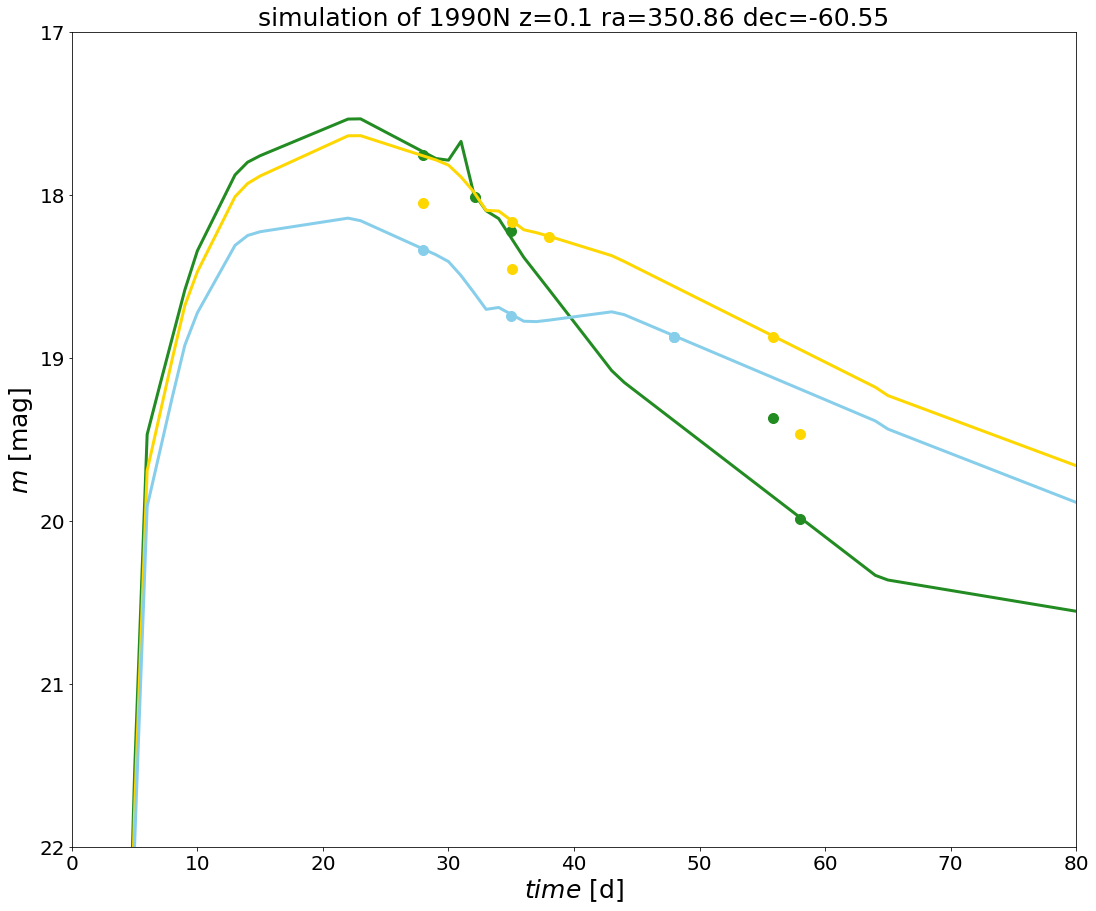

In [265]:
color = ['forestgreen', 'gold', 'skyblue', 'orange']
fig, axs = plt.subplots(1,1,figsize=(18,15))
for j, f in enumerate(['g','r','i']):
    c=color[j]
    filters=obs[lc_list[0]][0.1]['filter']==f
    mag =obs_template['magobs']['1990N'][0.1][f]
    ph = obs_template['phobs']['1990N'][0.1][f]-obs_template['phobs']['1990N'][0.1][f][mag==max(mag)]
    maglc =obs[lc_list[0]][0.1]['mag'][filters]
    phlc = obs[lc_list[0]][0.1]['epoch'][filters]-min(obs[lc_list[0]][0.1]['epoch'][filters])+28
    axs.plot(ph, mag,'-',lw=3,color=c)
    axs.plot(phlc, maglc,'o',color=c,markersize=10)
    axs.invert_yaxis()
    axs.set_ylim([22,17])
    axs.set_xlim([0,80])
    axs.set_xlabel(r'$time$ [d]',fontsize=25)
    axs.set_ylabel(r'$m$ [mag]',fontsize=25)
    axs.set_title(r'simulation of 1990N z=0.1 ra={} dec={}'.format(
    np.round(obs[lc_list[0]][0.1]['coo'][0],2),np.round(obs[lc_list[0]][0.1]['coo'][1],2)),fontsize=25)
    axs.tick_params('both', labelsize=20)

In [279]:
lc_list = glob.glob('LC_ML_baseline_nexp1_v1.7_10yrs/*dat')
lc_list[0:10]

['LC_ML_baseline_nexp1_v1.7_10yrs/LSST_1990N_z=0.1_ra151.85_dec2.29_0.dat',
 'LC_ML_baseline_nexp1_v1.7_10yrs/LSST_1990N_z=0.1_ra151.85_dec2.29_1.dat',
 'LC_ML_baseline_nexp1_v1.7_10yrs/LSST_1990N_z=0.1_ra151.85_dec2.29_2.dat',
 'LC_ML_baseline_nexp1_v1.7_10yrs/LSST_1990N_z=0.1_ra151.85_dec2.29_3.dat',
 'LC_ML_baseline_nexp1_v1.7_10yrs/LSST_1990N_z=0.1_ra151.85_dec2.29_4.dat',
 'LC_ML_baseline_nexp1_v1.7_10yrs/LSST_1990N_z=0.1_ra151.85_dec2.29_5.dat',
 'LC_ML_baseline_nexp1_v1.7_10yrs/LSST_1990N_z=0.1_ra151.85_dec2.29_6.dat',
 'LC_ML_baseline_nexp1_v1.7_10yrs/LSST_1990N_z=0.1_ra151.85_dec2.29_7.dat',
 'LC_ML_baseline_nexp1_v1.7_10yrs/LSST_1990N_z=0.1_ra151.85_dec2.29_8.dat',
 'LC_ML_baseline_nexp1_v1.7_10yrs/LSST_1992A_z=0.1_ra151.85_dec2.29_0.dat']

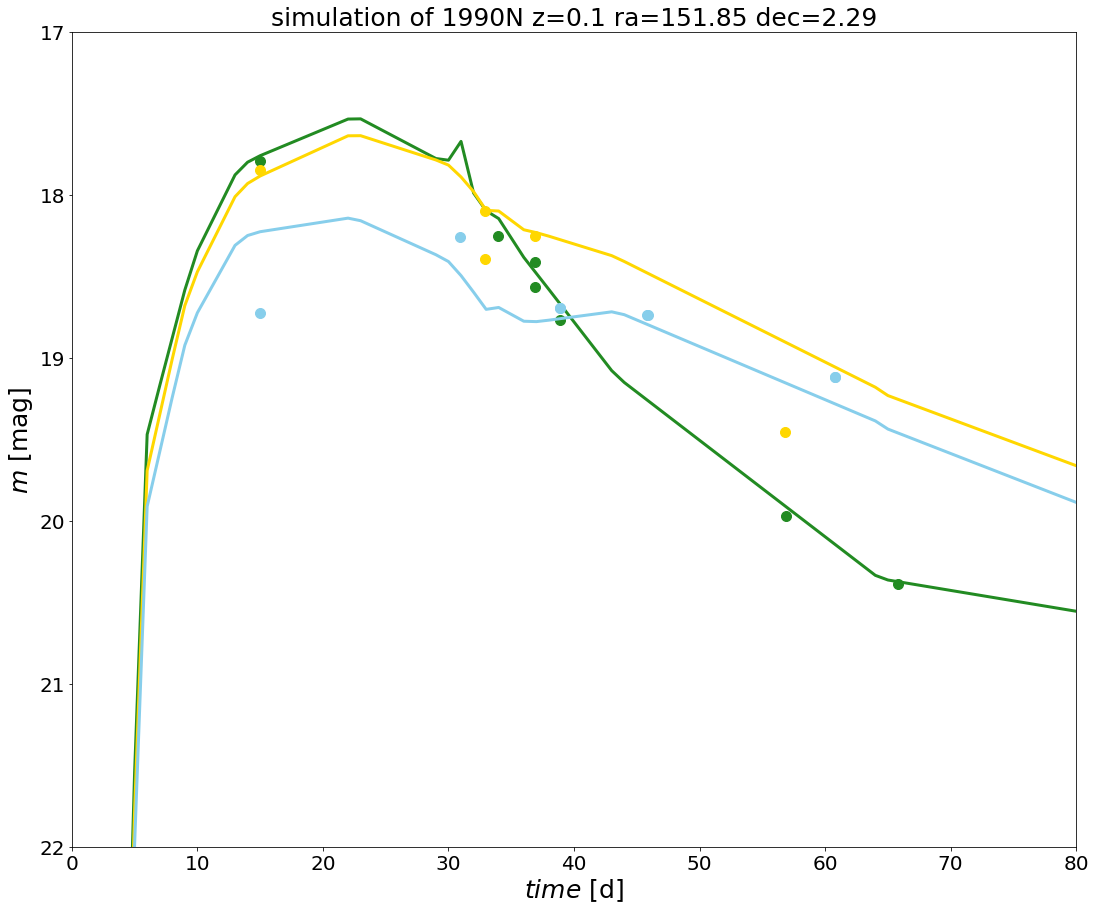

In [286]:
color = ['forestgreen', 'gold', 'skyblue', 'orange']
fig, axs = plt.subplots(1,1,figsize=(18,15))
for j, f in enumerate(['g','r','i']):
    c=color[j]
    filters=obs[lc_list[0]][0.1]['filter']==f
    mag =obs_template['magobs']['1990N'][0.1][f]
    ph = obs_template['phobs']['1990N'][0.1][f]-obs_template['phobs']['1990N'][0.1][f][mag==max(mag)]
    maglc =obs[lc_list[0]][0.1]['mag'][filters]
    phlc = obs[lc_list[0]][0.1]['epoch'][filters]-min(obs[lc_list[0]][0.1]['epoch'][filters])+15
    axs.plot(ph, mag,'-',lw=3,color=c)
    axs.plot(phlc, maglc,'o',color=c,markersize=10)
    axs.invert_yaxis()
    axs.set_ylim([22,17])
    axs.set_xlim([0,80])
    axs.set_xlabel(r'$time$ [d]',fontsize=25)
    axs.set_ylabel(r'$m$ [mag]',fontsize=25)
    axs.set_title(r'simulation of 1990N z=0.1 ra={} dec={}'.format(
    np.round(obs[lc_list[0]][0.1]['coo'][0],2),np.round(obs[lc_list[0]][0.1]['coo'][1],2)),fontsize=25)
    axs.tick_params('both', labelsize=20)

### simulated coordinates

In [15]:
ra_lc,dec_lc=[],[]
for i in range(len(df17['Ia_test_2']['SN_coo'])):
    ra_lc.append(df17['Ia_test_2']['SN_coo'][i][0])
    dec_lc.append(df17['Ia_test_2']['SN_coo'][i][1])
ra_lc=np.array(ra_lc)
dec_lc=np.array(dec_lc)

In [62]:
ra_metric,dec_metric=[],[]
for i in range(len(df17['Ia_test_2']['class'])):
    ra_df,dec_df=coo_df['Ia_test_2'][i][0]*360/(2*np.pi),coo_df['Ia_test_2'][i][1]*360/(2*np.pi)
    ra_metric.append(ra_df)
    dec_metric.append(dec_df)
ra_metric=np.array(ra_metric)
dec_metric=np.array(dec_metric)

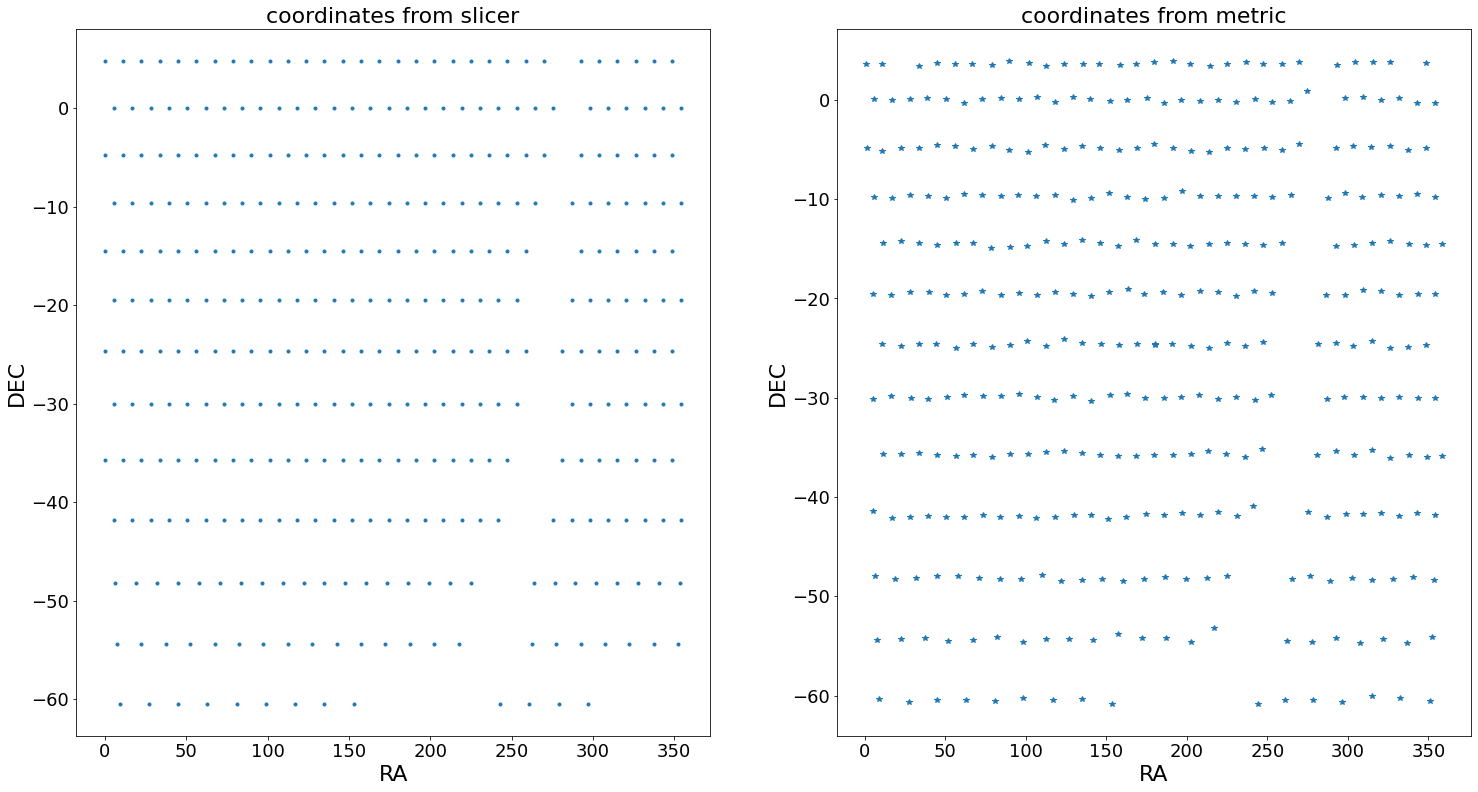

In [69]:
fig,ax=plt.subplots(1,2,figsize=(25,13))
ax[0].plot(ra_metric,dec_metric,'.')
ax[0].set_title('coordinates from slicer',fontsize=22)
ax[0].set_xlabel('RA',fontsize=22)
ax[0].set_ylabel('DEC',fontsize=22)
ax[0].tick_params('both', labelsize=18)
ax[1].plot(ra_lc,dec_lc,'*')
ax[1].set_title('coordinates from metric',fontsize=22)
ax[1].set_xlabel('RA',fontsize=22)
ax[1].set_ylabel('DEC',fontsize=22)
ax[1].tick_params('both', labelsize=18)

In [ ]:
df17_ops['Ia_familyOps_COSMOS']['baseline_nexp1_v1.7_10yrs']['time_expl']

In [200]:
np.where(np.array(pixid)==381)

(array([42]),)

In [193]:
pixid=[]
for coo in df17['Ia_test_2']['SN_coo']:
    ra,dec=coo[0],coo[1]
    pixid.append(radec2pix(8,np.radians(ra), np.radians(dec)))

### COSMOS example

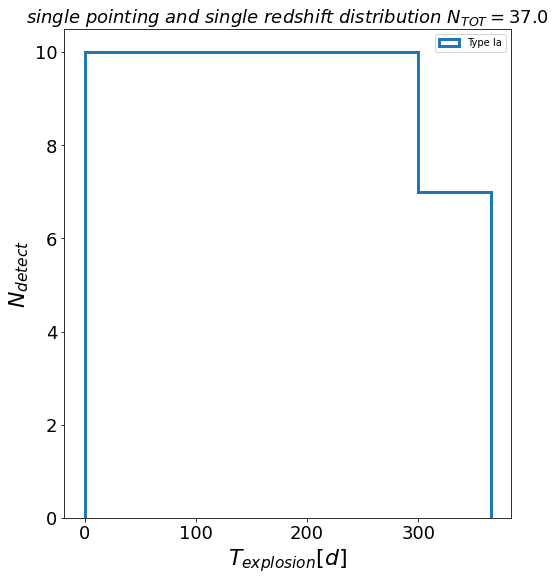

In [201]:
fig, ax=plt.subplots(1,figsize=(8,9))
#for i, key in enumerate(df17.keys()):   
texpl=df17['Ia_test_2']['time_expl'][42].tolist()[0.1]
texpl=np.array(texpl)-min(np.array(texpl))
v,b,p=ax.hist(texpl,np.array([0,100,200,300,365]), histtype='step',linewidth=3,align='mid',label='Type Ia')
ax.set_xlabel(r'$T_{explosion}[d]$',fontsize=22)
ax.set_ylabel(r'$N_{detect}$',fontsize=22)
ax.set_title(r'$single~ pointing~ and~ single~ redshift~ distribution~ N_{TOT}=$'+'{}'.format(v.sum()),fontsize=18)
ax.tick_params('both', labelsize=18)
plt.legend()

### total footprint

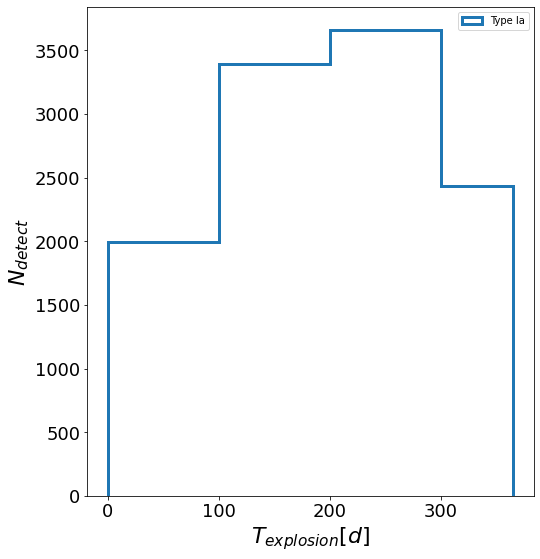

In [202]:
fig, ax=plt.subplots(1,figsize=(8,9))
e=[]
for i, key in enumerate(df17['Ia_test_2']['time_expl']):
    e.append(df17['Ia_test_2']['time_expl'][i].tolist()[0.1])
explt=np.concatenate(e)
explt=explt-min(explt)
ax.hist(explt,np.array([0,100,200,300,365]), histtype='step',linewidth=3,align='mid',label='Type Ia')
ax.set_xlabel(r'$T_{explosion}[d]$',fontsize=22)
ax.set_ylabel(r'$N_{detect}$',fontsize=22)
#ax.set_title(r'$N_{TOT}=106486$',fontsize=22)
ax.tick_params('both', labelsize=18)
plt.legend()
#plt.savefig('./Figure/hist_expl_v1.4_sD1_nexp37_nsn1_Ia.pdf')

In [17]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

In [102]:
from pylab import cm
def plt_mlw(ax,ra,dec,org=0,projection='mollweide',c= 'null', vmin=0,vmax=1, dicts={}):
    args={'colormap': None,'marker':'o','linewidths':0,'title':'mlw_plot','xlabel':'x','ylabel':'y', 'fontsize':12,'cbartitle': 'score','psize':100}
    if dicts:
        args.update(dicts)
    if args['colormap']:
        cmap = cm.get_cmap(args['colormap'])
    else:
        cmap=None
        
    if c =='null':
        c= np.ones(len(ra))
    else:
        c=c
     
    x = np.remainder(ra+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    #ax = fig.add_subplot(111, projection=projection)
    ax.set_title(args['title'])
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis    
    ax.title.set_fontsize(12)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    im=plt.scatter(np.radians(x),np.radians(dec),c=c, s=args['psize'],cmap=cmap, marker = args['marker'], vmin = vmin, vmax = vmax, linewidths = args['linewidths'], zorder = 10)
    #ax.tick_params('both', labelsize=14)
    if cmap:
        cb=plt.colorbar(im,aspect=50,orientation='horizontal')
        cb.set_label(args['cbartitle'], size=12)
        for t in cb.ax.get_xticklabels():
             t.set_fontsize(12)

In [148]:
import lsst.sims.maf.db as db
opsdb = db.OpsimDatabase('/home/idies/workspace/lsst_cadence/FBS_1.7/baseline_nexp1_v1.7_10yrs.db')
ddfInfo(opsdb, 'COSMOS')

{'proposalId': 4, 'Coord': (150.1, 2.18)}

### Fraction of correctly classified SNe as function of number of visits

In [80]:
fractions={'Ia':None,'II':None,'Ibc':None}

for j, key in enumerate(fractions.keys()):
    c = np.zeros(np.size(df17['Ia_test_2']['class']))
    for l,k in enumerate(df17['Ia_test_2']['class'][0].index):
        o=[]
        
        for i in range(len(df17['Ia_test_2']['class'])):
            
            if df17['Ia_test_2']['class'][i].iloc[l]['nlc'][0]!=0:
                o.append(df17['Ia_test_2']['class'][i].iloc[l][key]/df17['Ia_test_2']['class'][i].iloc[l]['nlc'][0])
            else:
                o.append(0)
        
        c+=np.array(o)
        
    fractions[key]=c/2



In [81]:

detected = []

for i in range(len(df17['Ia_test_2']['class'])):

    det=0
    for l,k in enumerate(df17['Ia_test_2']['class'][0].index):
        det+=df17['Ia_test_2']['class'][i].iloc[l]['nlc'][0]/np.sum(df17['Ia_test_2']['class'][i].iloc[l]['nlc'])

    detected.append(det/2)
        


In [82]:
nvis=[]
see=[]
m5=[]
filters=[]
for i in range(len(df17['Ia_test_2']['class'])):
    filters.append(np.size(np.unique(df17['get_Col']['filter'][i])))
for i in range(len(df17['Ia_test_2']['class'])):
    nvis.append(np.size(df17['get_Col']['observationStartMJD'][i]))
for i in range(len(df17['Ia_test_2']['class'])):
    see.append(np.median(df17['get_Col']['seeingFwhmEff'][i]))
for i in range(len(df17['Ia_test_2']['class'])):
    m5.append(np.median(df17['get_Col']['fiveSigmaDepth'][i]))

In [151]:
nvis_filt = {'g':[],'r':[],'i':[]}
pairs={'id':[],'pairs':[]}
for i in range(len(df17['Ia_test_2']['class'])):    
    idx_g=np.where(df17['get_Col']['filter'][i]=='g')
    idx_r=np.where(df17['get_Col']['filter'][i]=='r')
    idx_i=np.where(df17['get_Col']['filter'][i]=='i')
    nvis_filt['g'].append(np.size(df17['get_Col']['observationStartMJD'][i][idx_g]))
    nvis_filt['r'].append(np.size(df17['get_Col']['observationStartMJD'][i][idx_r]))
    nvis_filt['i'].append(np.size(df17['get_Col']['observationStartMJD'][i][idx_i]))
    epoch_g = df17['get_Col']['observationStartMJD'][i][idx_g]
    epoch_r = df17['get_Col']['observationStartMJD'][i][idx_r]
    epoch_i = df17['get_Col']['observationStartMJD'][i][idx_i]
    gr=[]
    ri=[]
    for g in epoch_g:
        gr.append(np.absolute(g-epoch_r))
    if gr: gr=np.concatenate(gr)
    ri=[] 
    for r in epoch_r:
        ri.append(np.absolute(r-epoch_i))
    if ri:ri=np.concatenate(ri)
    epoch_pairs=np.concatenate([gr,ri])
    pairs['id'].append(np.ones(len(epoch_pairs),dtype=int)*int(i))
    pairs['pairs'].append(epoch_pairs)

In [152]:
p=np.concatenate(pairs['pairs'])
pairs['pairs']=p[p<1]
p_id=np.concatenate(pairs['id'])
pairs['id']=p_id[p<1]

In [85]:
zfractions={'Ia':{z:None for z in df17['Ia_test_2']['class'][0].index},
            'II':{z:None for z in df17['Ia_test_2']['class'][0].index},
            'Ibc':{z:None for z in df17['Ia_test_2']['class'][0].index}}
for j, key in enumerate(fractions.keys()):
    c = np.zeros(np.size(df17['Ia_test_2']['class']))
    for l,k in enumerate(df17['Ia_test_2']['class'][0].index):
        o=[]
        for i in range(len(df17['Ia_test_2']['class'])):
            if df17['Ia_test_2']['class'][i].iloc[l]['nlc'][0]!=0:
                o.append(df17['Ia_test_2']['class'][i].iloc[l][key]/df17['Ia_test_2']['class'][i].iloc[l]['nlc'][0])
            else:
                o.append(0)
           
        zfractions[key][k]=np.array(o)

In [86]:
nvis=np.array(nvis)
see=np.array(see)
m5=np.array(m5)

In [87]:
detected=np.array(detected)
d10,d40,d100= np.where(detected<0.25), np.where((detected>0.25) & (detected<0.50)),np.where((detected>0.50)) 
dv=[d10,d40,d100]

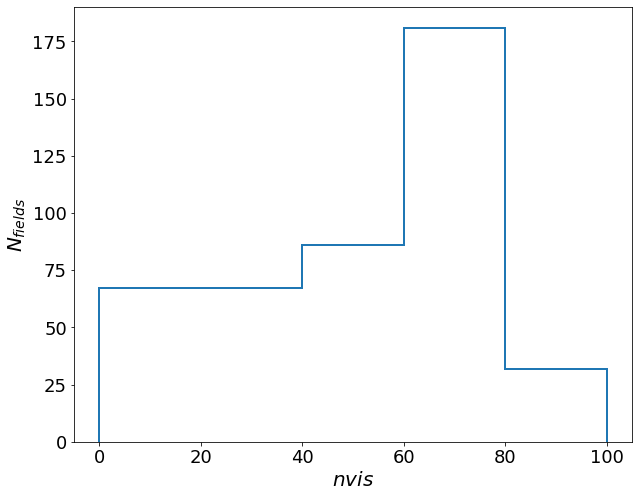

In [89]:
plt.figure(figsize=(10,8))
values_nv, bins_nv, p= plt.hist(nvis,np.array([0,40,60,80,100]), histtype='step', align='mid', lw=2)
plt.xlabel(r"$nvis$",fontsize= 20)
plt.ylabel(r"$N_{fields}$",fontsize= 20)
plt.tick_params('both', labelsize=18)
plt.show()

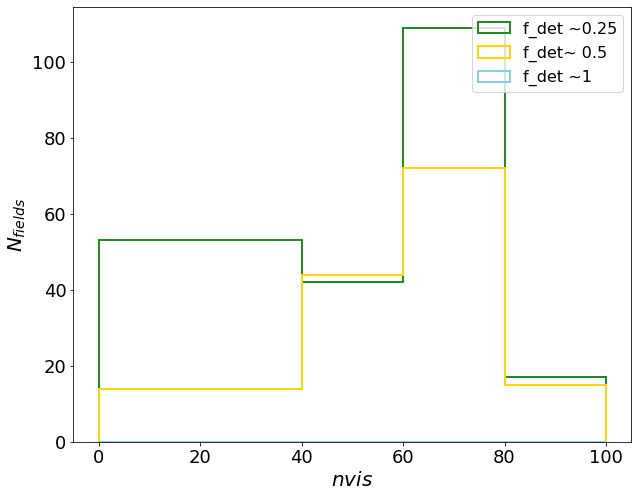

In [88]:
plt.figure(figsize=(10,8))
color = ['forestgreen', 'gold', 'skyblue', 'orange']
val=[]
for i, (n,name) in enumerate(zip(dv,['f_det ~0.25','f_det~ 0.5',  'f_det ~1'])):
    c= color[i]
    #for z, lt in zip([0.1],['solid']):
    v,b,p=plt.hist(nvis[n],np.array([0,40,60,80,100]), histtype='step',color=c, align='mid', lw=2,label=name)    
    val.append(v)
plt.xlabel(r"$nvis$",fontsize= 20)
plt.ylabel(r"$N_{fields}$",fontsize= 20)
plt.legend(fontsize=16)
plt.tick_params('both', labelsize=18)
plt.show()

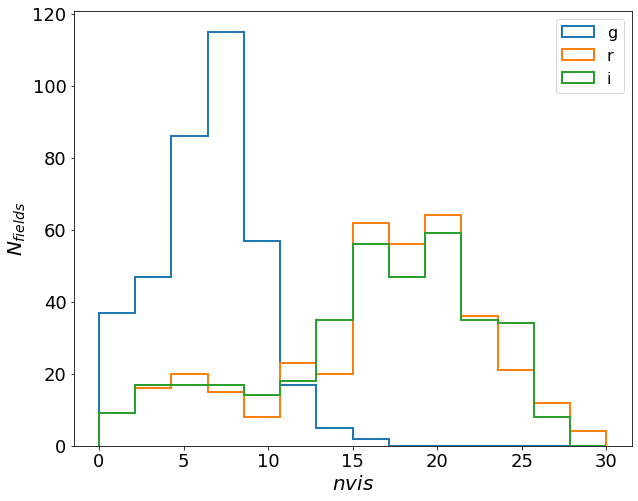

In [90]:
plt.figure(figsize=(10,8))
for i, f in enumerate(['g','r','i']):
    plt.hist(np.array(nvis_filt[f]),np.linspace(0,30,15), histtype='step', align='mid', lw=2,label=f)
plt.xlabel(r"$nvis$",fontsize= 20)
plt.ylabel(r"$N_{fields}$",fontsize= 20)
plt.legend(fontsize=16)
plt.tick_params('both', labelsize=18)
plt.show()

In [91]:
f25,f50,f100= np.where(fractions['Ia']<0.25), np.where((fractions['Ia']>0.25) & (fractions['Ia']<0.50)),np.where((fractions['Ia']>0.50)) 


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [92]:
nvis10,nvis40,nvis70,nvis100= np.where(nvis<10), np.where((nvis>10) & (nvis<40)),np.where((nvis>40) & (nvis<70)),np.where((nvis>70) & (nvis<100))

In [95]:
see9,see11,see13,see15= np.where(see[nvis70]<0.9), np.where((see[nvis70]>0.9) & (see[nvis70]<1.1)),np.where((see[nvis70]>1.1) & (see[nvis70]<1.3)),np.where((see[nvis70]>1.3) & (see[nvis70]<1.5))


In [96]:
nv =[nvis10,nvis40,nvis70,nvis100]
sv =[see9,see11,see13,see15=]
fv =[f25,f50,f100]

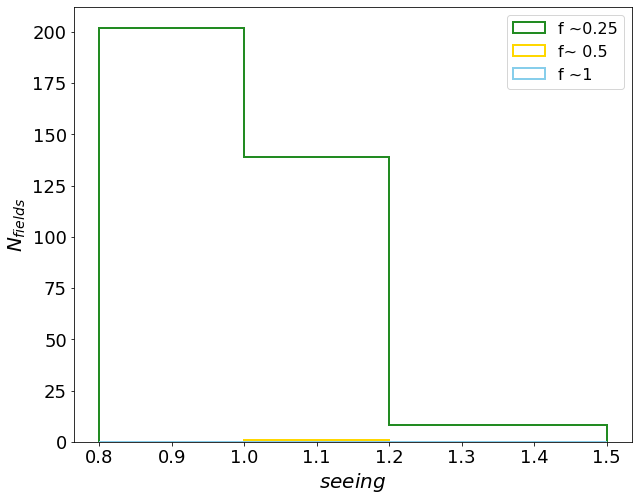

In [97]:
plt.figure(figsize=(10,8))
color = ['forestgreen', 'gold', 'skyblue', 'orange']
for i, (n,name) in enumerate(zip(fv,['f ~0.25','f~ 0.5', 'f ~1'])):
    c= color[i]
    #for z, lt in zip([0.1],['solid']):
    plt.hist(see[n],np.array([0.8,1,1.2,1.5]), histtype='step',color=c, align='mid', lw=2,label=name)
plt.xlabel(r"$seeing$",fontsize= 20)
plt.ylabel(r"$N_{fields}$",fontsize= 20)
plt.legend(fontsize=16)
plt.tick_params('both', labelsize=18)
plt.show()

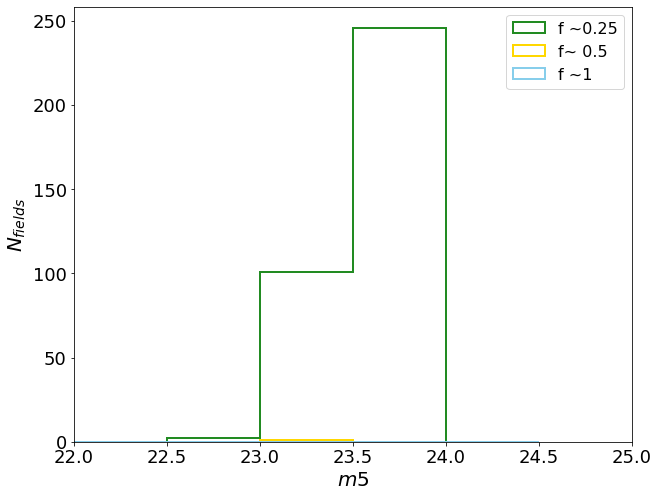

In [98]:
plt.figure(figsize=(10,8))
color = ['forestgreen', 'gold', 'skyblue', 'orange']
for i, (n,name) in enumerate(zip(fv,['f ~0.25','f~ 0.5', 'f ~1'])):
    c= color[i]
    #for z, lt in zip([0.1],['solid']):
    plt.hist(m5[n],np.linspace(20,24.5,10), histtype='step',color=c, align='mid', lw=2,label=name)
plt.xlabel(r"$m5$",fontsize= 20)
plt.ylabel(r"$N_{fields}$",fontsize= 20)
plt.legend(fontsize=16)
plt.xlim([22,25])
plt.tick_params('both', labelsize=18)
plt.show()

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


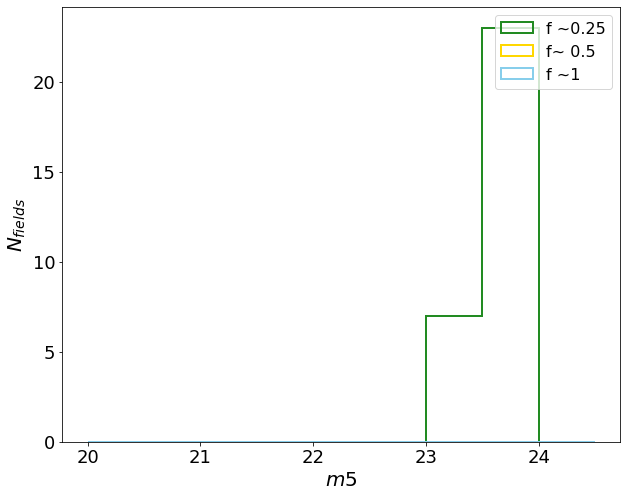

In [134]:
plt.figure(figsize=(10,8))
color = ['forestgreen', 'gold', 'skyblue', 'orange']
val=[]
nn=np.where(nvis>80)
f_nn10,f_nn40,f_nn100= np.where(fractions['Ia'][nn]<0.25), np.where((fractions['Ia'][nn]>0.25) & (fractions['Ia'][nn]<0.50)),np.where((fractions['Ia'][nn]>0.50)) 
fv_nn=[f_nn10,f_nn40,f_nn100]
for i, (n,name) in enumerate(zip(fv_nn,['f ~0.25','f~ 0.5', 'f ~1'])):
    c= color[i]
    #for z, lt in zip([0.1],['solid']):
    v,b,p=plt.hist(m5[nn][n],np.linspace(20,24.5,10), histtype='step',color=c, align='mid', lw=2,label=name)    
    val.append(v)
plt.xlabel(r"$m5$",fontsize= 20)
plt.ylabel(r"$N_{fields}$",fontsize= 20)
plt.legend(fontsize=16)
plt.tick_params('both', labelsize=18)
plt.show()

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


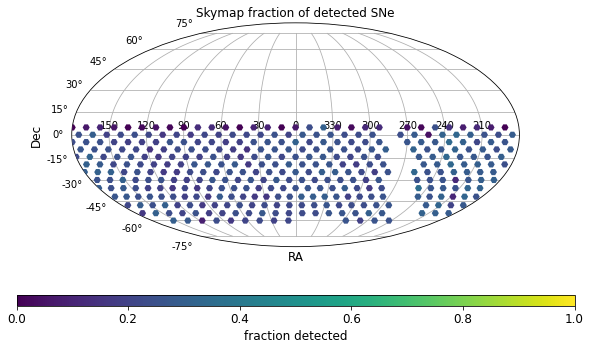

In [103]:
fig=plt.figure(figsize=(10,20))
for i, key in enumerate(['Ia']):
        ax= fig.add_subplot(3,1,j+1, projection='mollweide')
        plt_mlw(ax,ra_metric,dec_metric,c=detected,vmin=0,vmax=1,dicts={'marker':'H','cbartitle':'fraction detected','colormap':'viridis','title': 'Skymap fraction of detected SNe'.format(key,z),'psize':50})
#plt.savefig('./Figure/skymap_fraction.pdf')

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


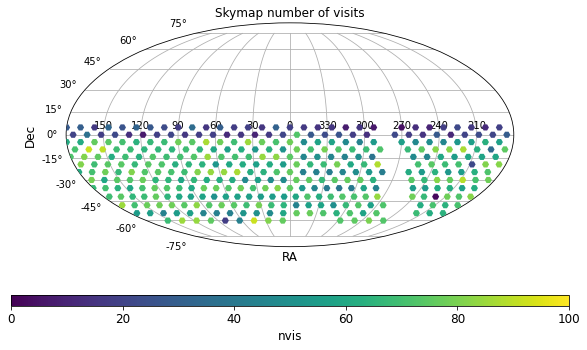

In [104]:
fig=plt.figure(figsize=(10,20))
for i, key in enumerate(['Ia']):
        ax= fig.add_subplot(3,1,j+1, projection='mollweide')
        plt_mlw(ax,ra_metric,dec_metric,c=nvis,vmin=0,vmax=100,dicts={'marker':'H','cbartitle':'nvis','colormap':'viridis','title': 'Skymap number of visits'.format(key,z),'psize':50})
#plt.savefig('./Figure/skymap_fraction.pdf')

### Skymap of the fraction of correctly classified SNe

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


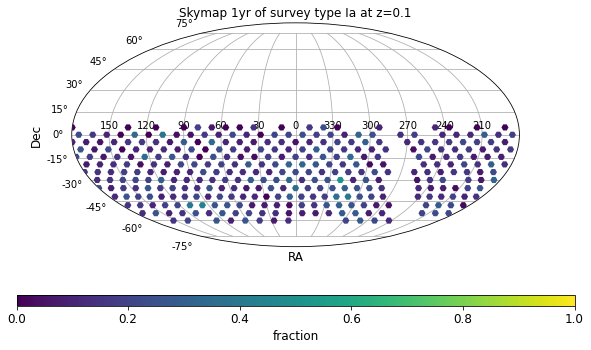

In [108]:
fig=plt.figure(figsize=(10,20))
for i, key in enumerate(['Ia']):
    for j, z in enumerate([0.1]):
        ax= fig.add_subplot(3,1,j+1, projection='mollweide')
        plt_mlw(ax,ra_metric,dec_metric,c=zfractions[key][z],vmin=0,vmax=1,dicts={'marker':'H','cbartitle':'fraction','colormap':'viridis','title': 'Skymap 1yr of survey type {} at z={}'.format(key,z),'psize':50})
#plt.savefig('./Figure/skymap_fraction.pdf')

the cell below allow to get the number of visits for all the opsims

we select one opsim representative for each family based on the results from Xialong et al 2021 (https://arxiv.org/abs/2107.10281 ) 

In [12]:
family = []
for db in dbRuns:
    family.append(db.split('_')[0])
np.unique(family)

array(['baseline', 'cadence', 'ddf', 'euclid', 'footprint', 'pair',
       'rolling', 'twi', 'u'], dtype='<U9')

In [13]:
dbfamily={}
for f in np.unique(family):
    dbfamily[f]=[]
    for db in dbRuns:
        if f == db.split('_')[0]:
            dbfamily[f].append(db)

{'baseline': ['baseline_nexp2_v1.7_10yrs', 'baseline_nexp1_v1.7_10yrs'],
 'cadence': ['cadence_drive_gl30v1.7_10yrs',
  'cadence_drive_gl200v1.7_10yrs',
  'cadence_drive_gl100_gcbv1.7_10yrs',
  'cadence_drive_gl100v1.7_10yrs',
  'cadence_drive_gl30_gcbv1.7_10yrs',
  'cadence_drive_gl200_gcbv1.7_10yrs'],
 'ddf': ['ddf_dither0.70_v1.7_10yrs',
  'ddf_dither1.00_v1.7_10yrs',
  'ddf_dither0.05_v1.7_10yrs',
  'ddf_dither0.00_v1.7_10yrs',
  'ddf_dither2.00_v1.7_10yrs',
  'ddf_dither1.50_v1.7_10yrs',
  'ddf_dither0.30_v1.7_10yrs',
  'ddf_dither0.10_v1.7_10yrs'],
 'euclid': ['euclid_dither2_v1.7_10yrs',
  'euclid_dither5_v1.7_10yrs',
  'euclid_dither1_v1.7_10yrs',
  'euclid_dither4_v1.7_10yrs',
  'euclid_dither3_v1.7_10yrs'],
 'footprint': ['footprint_0_v1.710yrs',
  'footprint_1_v1.710yrs',
  'footprint_3_v1.710yrs',
  'footprint_2_v1.710yrs',
  'footprint_7_v1.710yrs',
  'footprint_6_v1.710yrs',
  'footprint_4_v1.710yrs',
  'footprint_5_v1.710yrs',
  'footprint_8_v1.710yrs'],
 'pair': ['pair_

In [16]:
dbmetric = ['baseline_nexp1_v1.7_10yrs','ddf_dither0.30_v1.7_10yrs','euclid_dither4_v1.7_10yrs', 
            'footprint_8_v1.710yrs','cadence_drive_gl30_gcbv1.7_10yrs',
            'rolling_scale1.0_nslice3_v1.7_10yrs','twi_pairs_mixed_repeat_v1.7_10yrs',
            'u_long_ms_30_v1.7_10yrs']

In [14]:
sngroupsIa ={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)}}

We run the metric on set of selected pointing based on the number of visits.

In [33]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)
names = ['ra', 'dec']
metriclcIa = SNclassification_metric(z=[0.1,0.9,0.7], metricName='Ia_familyOps_COSMOS', mjdCol='observationStartMJD',
                              m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', 
                              DecCol='fieldDec',surveyDuration=surveyDuration,
                              templates= sngroupsIa,explosiontime=expl_range,
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                              nFilters=1,ndetect=3,dataout=True)
#transObjects = np.zeros(np.shape(fields[run])[0], dtype=list(zip(names, [float]*len(names))))
transObjects = np.zeros(1, dtype=list(zip(names, [float]*len(names))))
transObjects['ra'], transObjects['dec'] = np.array([151.875, 2.3880154632687733])
slicer = slicers.UserPointsSlicer(transObjects['ra'], transObjects['dec'], latLonDeg=True)
surveyDuration = 1
init = 1
sqlconstraint_WFD = '(filter= "u" or filter= "g" or  filter = "r" or filter="i"  or filter="z")'
sqlconstraint_WFD+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25)
metriclc_trans_Ia= metricBundles.MetricBundle(metriclcIa, slicer, sqlconstraint_WFD)
bundleDict={'Ia_familyOps_COSMOS':metriclc_trans_Ia}
for run in dbmetric:
    warnings.filterwarnings('ignore')
    print('##############\n')
    print('{} is running\n'.format(run))
    print('##############\n')
    start_time = time.time()
    metriclc_trans_Ia.setRunName(run)
    #metriclc_get_Colmetric.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    bgrouplc.runAll()
    print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
    print('####################\n')

I'm reading the templates
1990N g B 0.1
1990N r R 0.1
1990N i R 0.1
1990N g B 0.8
1990N r B 0.8
1990N i B 0.8
1992A g B 0.1
1992A r R 0.1
1992A i R 0.1
1992A g B 0.8
1992A r B 0.8
1992A i B 0.8
1994D g B 0.1
1994D r R 0.1
1994D i R 0.1
1994D g B 0.8
1994D r B 0.8
1994D i B 0.8
2002bo g B 0.1
2002bo r R 0.1
2002bo i R 0.1
2002bo g B 0.8
2002bo r B 0.8
2002bo i B 0.8
1991T g B 0.1
1991T r R 0.1
1991T i R 0.1
1991T g B 0.8
1991T r B 0.8
1991T i B 0.8
1999ee g B 0.1
1999ee r R 0.1
1999ee i R 0.1
1999ee g B 0.8
1999ee r B 0.8
1999ee i B 0.8
1991bg g B 0.1
1991bg r R 0.1
1991bg i R 0.1
1991bg g B 0.8
1991bg r B 0.8
1991bg i B 0.8
2000cx g B 0.1
2000cx r R 0.1
2000cx i R 0.1
2000cx g B 0.8
2000cx r B 0.8
2000cx i B 0.8
2002cx g B 0.1
2002cx r R 0.1
2002cx i R 0.1
2002cx g B 0.8
2002cx r B 0.8
2002cx i B 0.8
##############

baseline_nexp1_v1.7_10yrs is running

##############

Querying database SummaryAllProps with constraint (filter= "u" or filter= "g" or  filter = "r" or filter="i"  or filte

In [36]:
resultDbs = getResultsDbs(outDir)
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)
# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in dbmetric:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [37]:
for runName in dbmetric:
    print(bundleDicts[runName].keys())

dict_keys([(1, 'Ia'), (2, 'get_Col'), (3, 'get_Col'), (4, 'Ia_test'), (5, 'Ia_familyOps'), (6, 'Ia_familyOps_test2'), (7, 'Ia_familyOps_COSMOS'), (8, 'Ia_familyOps_COSMOS')])
dict_keys([(1, 'get_Col'), (2, 'Ia_familyOps'), (3, 'Ia_familyOps_test2'), (4, 'Ia_familyOps_COSMOS'), (5, 'Ia_familyOps_COSMOS')])
dict_keys([(1, 'get_Col'), (2, 'Ia_familyOps'), (3, 'Ia_familyOps_test2'), (4, 'Ia_familyOps_COSMOS'), (5, 'Ia_familyOps_COSMOS')])
dict_keys([(1, 'get_Col'), (2, 'Ia_familyOps'), (3, 'Ia_familyOps_test2'), (4, 'Ia_familyOps_COSMOS'), (5, 'Ia_familyOps_COSMOS')])
dict_keys([(1, 'get_Col'), (2, 'Ia_familyOps'), (3, 'Ia_familyOps_test2'), (4, 'Ia_familyOps_COSMOS')])
dict_keys([(1, 'get_Col'), (2, 'Ia_familyOps'), (3, 'Ia_familyOps_test2'), (4, 'Ia_familyOps_COSMOS')])
dict_keys([(1, 'get_Col'), (2, 'Ia_familyOps'), (3, 'Ia_familyOps_COSMOS')])
dict_keys([(1, 'get_Col'), (2, 'Ia_familyOps'), (3, 'Ia_familyOps_COSMOS')])


In [83]:
db

'baseline_nexp1_v1.7_10yrs'

In [39]:
df17_ops=pd.DataFrame(index = dbmetric, columns = ['Ia_familyOps_COSMOS'])
coo={}
for db in dbmetric:
    if (3, 'Ia_familyOps_COSMOS') in bundleDicts[db].keys():
        metric = (3, 'Ia_familyOps_COSMOS')
    if (4, 'Ia_familyOps_COSMOS') in bundleDicts[db].keys():
        metric = (4, 'Ia_familyOps_COSMOS')
    if (5, 'Ia_familyOps_COSMOS') in bundleDicts[db].keys():
        metric = (5, 'Ia_familyOps_COSMOS')
    if (8, 'Ia_familyOps_COSMOS') in bundleDicts[db].keys():
        metric = (8, 'Ia_familyOps_COSMOS')
    arr=bundleDicts[db][metric].metricValues.data
    arr_=arr[np.where(arr!=None)]
    df17_ops[metric[1]][db] = pd.DataFrame.from_records(arr_)

In [124]:
cm = plt.get_cmap('tab10').colors

In [49]:
zfrac={db:{'Ia':{z:0 for z in [0.1,0.8]}}for db in dbmetric}#,'II':{z:0 for z in [0.1,0.8]},'Ibc':{z:0 for z in [0.1,0.8]}}
miss_class= {db:{'Ia':{'II':{z:0 for z in [0.1,0.8]},'Ibc':{z:0 for z in [0.1,0.8]}}}for db in dbmetric}#,'II':{'Ia':{z:0 for z in [0.1,0.8]},'Ibc':{z:0 for z in [0.1,0.8]}},'Ibc':{'Ia':{z:0 for z in [0.1,0.8]},'II':{z:0 for z in [0.1,0.8]}}}
for db in dbmetric:
    for j, key in enumerate(zfrac[db].keys()):
        for l,k in enumerate(zfrac[db][key].keys()):
            c=0
            norm = np.nansum(np.array([df17_ops['Ia_familyOps_COSMOS'][db]['class'][i].iloc[l]['noClass'] for i in range(len(df17_ops['Ia_familyOps_COSMOS'][db]['class']))]))
            if norm ==0:
                p=0
            else:
                p=np.nansum(np.array([df17_ops['Ia_familyOps_COSMOS'][db]['class'][i].iloc[l][key] for i in range(len(df17_ops['Ia_familyOps_COSMOS'][db]['class']))]))/norm
            zfrac[db][key][k] += p
        
for db in dbmetric:
    for j, key in enumerate(miss_class[db].keys()):
        for j, mk in enumerate(miss_class[db][key].keys()):
            for l,k in enumerate(miss_class[db][key][mk].keys()):
                norm = np.nansum(np.array([df17_ops['Ia_familyOps_COSMOS'][db]['class'][i].iloc[l]['noClass'] for i in range(len(df17_ops['Ia_familyOps_COSMOS'][db]['class']))]))
                if norm==0:
                    p=0
                else:
                    p=np.nansum(np.array([df17_ops['Ia_familyOps_COSMOS'][db]['class'][i].iloc[l][mk] for i in range(len(df17_ops['Ia_familyOps_COSMOS'][db]['class']))]))/norm
                miss_class[db][key][mk][k] += p

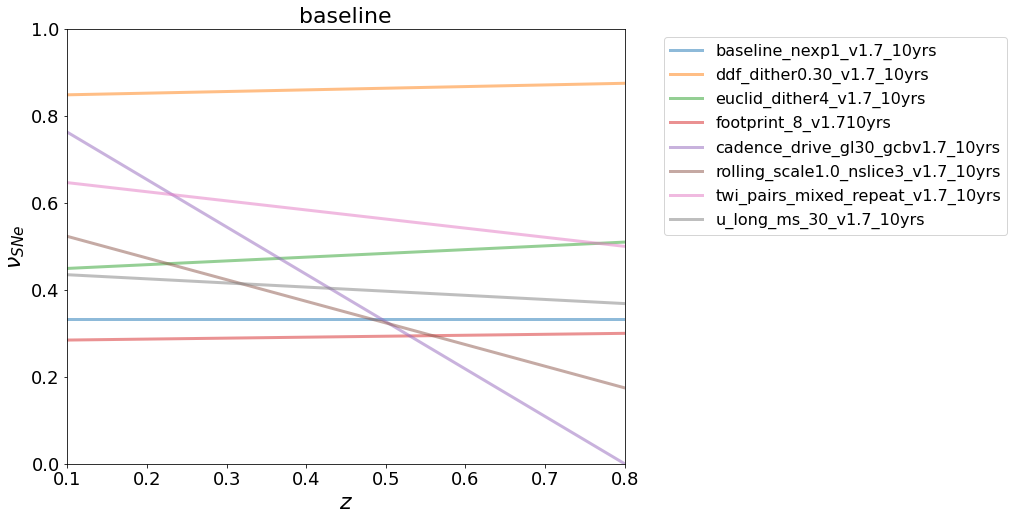

In [125]:
fig, axes = plt.subplots(1,1,figsize=(10,8))
for db,c in zip(dbmetric,cm[0:len(dbmetric)]):
    for i, t in enumerate(zfrac[db].keys()):
        if t=='Ia':
            m1,m2='II','Ibc'
        elif t=='II':
            m1,m2='Ia','Ibc'
        elif t=='Ibc':
            m1,m2='Ia','II'
        axes.plot(zfrac[db][t].keys(),np.array([ zfrac[db][t][k] for k in zfrac[db][t].keys()]),'-',lw=3,color = c,alpha=0.5 ,label=db)
        #axes.plot(zfrac[db][t].keys(),np.array([ miss_class[db][t][m1][k] for k in zfrac[db][t].keys()]),'--',lw=3,color = 'gray' ,label=m1)
        #axes.plot(zfrac[db][t].keys(),np.array([ miss_class[db][t][m2][k] for k in zfrac[db][t].keys()]),'-.',lw=3,color = 'gray' ,label=m2)    
    axes.set_ylabel(r'$\nu_{SNe}$', fontsize=22)
    axes.set_xlabel(r'$z$', fontsize=22)
    axes.set_xlim([0,1])
    axes.set_xlim([0.099,0.8])
    axes.tick_params('both', labelsize=18)
    axes.legend(loc=1,bbox_to_anchor=(1.2, .5, 0.5, 0.5),fontsize=16)
    axes.set_title('baseline', fontsize=22)
    axes.set_ylim([0,1])